# Python for Finance Cookbook

## Purpose
1. Use powerful Python libraries such as pandas, NumPy, and SciPy to analyze your financial data
2. Explore unique recipes for financial data analysis and processing with Python
3. Estimate popular financial models such as CAPM and GARCH using a problem-solution approach

## References
1. https://subscription.packtpub.com/book/data/9781789618518

# Setup:  Library  Import

In [3]:
    # Data manipulation
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data as wb
    # Visualizations
import matplotlib as plt
%matplotlib inline
import chart_studio.plotly as py
import plotly
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)    
    # Cufflinks binds Plotly directly to pandas dataframes.
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')
    # IMPORT API FUNCTIONS
import quandl
import yfinance as yf
from yahoofinancials import YahooFinancials
import requests
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries
import iexfinance
    # MISC LIB IMPORTS
import jupytemplate
import locale
from datetime import date, datetime
from nsepy import get_history
import os
import time
import csv
import json
from patsy import dmatrices
    # lOCAL LIBRARY IMPORT
import jupytemplate
import sys
print(jupytemplate.get_template_path())

c:\users\gordo\appdata\local\programs\python\python37\lib\site-packages\jupytemplate\jupytemplate\template.ipynb


# Multi-Factor Models

## Implementing the CAPM in Python

In [1]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [2]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2014-01-01'
END_DATE = '2018-12-31'

In [3]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

In [4]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()

In [5]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance

In [6]:
y = X.pop('asset')
X = sm.add_constant(X)

capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     31.87
Date:                Sun, 08 Mar 2020   Prob (F-statistic):           5.44e-07
Time:                        03:03:05   Log-Likelihood:                 75.306
No. Observations:                  59   AIC:                            -146.6
Df Residuals:                      57   BIC:                            -142.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.009      1.950      0.0

[*********************100%***********************]  1 of 1 completed


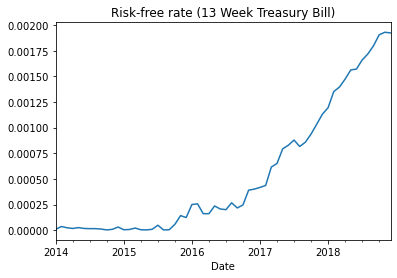

In [7]:
N_DAYS = 90

df_rf = yf.download('^IRX', start=START_DATE, end=END_DATE)

rf = df_rf.resample('M').last().Close / 100

rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  
rf = (rf ** 30) - 1 

rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

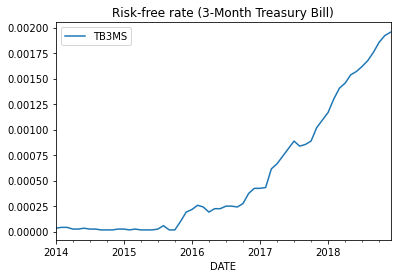

In [9]:
import pandas_datareader.data as web

rf = web.DataReader('TB3MS', 'fred', start=START_DATE, 
                     end=END_DATE)

rf = (1 + (rf / 100)) ** (1 / 12) - 1

rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

## Implementing the rolling three-factor model on a portfolio of assets


In [10]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf

In [13]:
RISKY_ASSET = 'FB'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

In [22]:
factor_df = pd.read_csv(r'C:/Users/gordo/Programming/Data_Bank/PACKT/COOKBOOK/F-F_Research_Data_Factors.csv',
                        skiprows=3)

STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

factor_df = factor_df[factor_df.index < start_of_annual]

In [23]:
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m') \
                      .dt.strftime("%Y-%m")
factor_df = factor_df.set_index('date')
factor_df = factor_df.loc[START_DATE:END_DATE]

In [24]:
factor_df = factor_df.apply(pd.to_numeric, 
                            errors='coerce') \
                     .div(100)

In [25]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True)

[*********************100%***********************]  1 of 1 completed


In [26]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'

In [27]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

In [28]:
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', 
                   data=ff_data).fit()
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     5.267
Date:                Sun, 08 Mar 2020   Prob (F-statistic):            0.00285
Time:                        03:13:22   Log-Likelihood:                 88.209
No. Observations:                  60   AIC:                            -168.4
Df Residuals:                      56   BIC:                            -160.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0101      0.008      1.318      0.1

In [29]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

In [30]:
get_available_datasets()[:5]


['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [31]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                         start='2014-01-01')

In [32]:
ff_dict.keys()
print(ff_dict['DESCR'])


F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202001 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2020 Kenneth R. French

  0 : (73 rows x 4 cols)
  1 : Annual Factors: January-December (6 rows x 4 cols)


In [33]:
ff_dict[0].head()


,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.85,-2.09,0.0
2014-02,4.65,0.34,-0.40,0.0
2014-03,0.43,-1.89,5.09,0.0
2014-04,-0.19,-4.24,1.14,0.0
2014-05,2.06,-1.86,-0.27,0.0


## Implementing the four- and five-factor models in Python


### Import the libraries:

In [60]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

### Define the parameters:

In [61]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

### Download the factor-related data:

In [62]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 
                                 'famafrench', start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

### Download the factor-related data:


In [63]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

### Calculate the monthly returns on the risky assets:

In [64]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
asset_df.index = asset_df.index.strftime('%Y-%m')

### Calculate the portfolio returns:

In [65]:
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                          WEIGHTS)

### Merge the datasets:

In [66]:
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

### Define a function for the rolling n-factor model:

In [67]:
def rolling_factor_model(input_data, formula, window_size):
    coeffs = []

    for start_index in range(len(input_data) - window_size + 1): 
        end_index = start_index + window_size

        ff_model = smf.ols(
            formula=formula,
            data=input_data[start_index:end_index]
        ).fit()
   
        coeffs.append(ff_model.params)

    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

### Estimate the rolling three-factor model and plot the results:

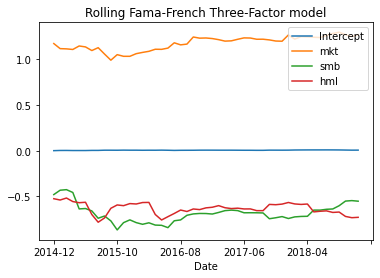

In [72]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60)
results_df.plot(title = 'Rolling Fama-French Three-Factor model')
print('')

### 

# Two

# Three